## Predicting Monthly Air Passengers with ARIMA Time Series Forecasting

- Time series analysis deals with sequences of data points collected over time and investigates their relation with time.
- This dataset contains the monthly number of airline passengers over a continuous period.
- Our goal is to build a model that can predict the number of passengers per month.
- With this capability, it becomes possible to anticipate and prepare for the future.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

#### 
### Load Data

In [2]:
df = pd.read_csv('AirPassengers.csv')
df.columns = ['month', 'passengers']
df

,month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
# set index to the start of the month

df['month'] = pd.to_datetime(df['month'], infer_datetime_format=True)
df = df.set_index(['month'])
df.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### 
### Clean Data

In [4]:
# check for missing values
df.loc[df.passengers.isnull()]

,passengers
month,


**Note:** No missing values

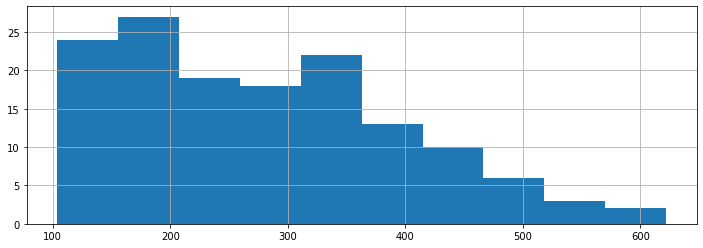

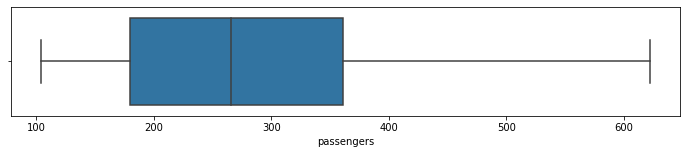

In [5]:
# outlier detection

# histogram
df['passengers'].hist(figsize=(12,4))

# boxplot
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x = df['passengers'], whis=1.5)  # whiskers = 1.5 x IQR (common industry standard)

**Note:** We can see a gradual decrease in the frequency of passengers per month at larger values, and the boxplot whiskers catch all values, i.e. no data points are visible above or below 1.5 times the interquartile range (Q1 to Q3).
<br><br>
From this, we can assume there are no outliers

#### 
### Discovery

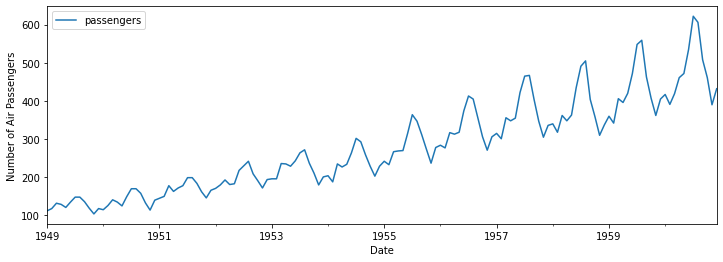

In [6]:
# plotting

df.plot(figsize=(12,4))
plt.xlabel('Date')
plt.ylabel('Number of Air Passengers')
plt.plot(df)

**Note:** We determine from visual inspection that data has an overall positive trend (thus, a non-constant mean), so let's check the stationarity.

#### 
### Testing Stationarity

When building a model for time series analysis, we need to separate the non-periodic trends to measure the periodic features of the data. In doing this, we are making the data stationary.

First, we need to determine the stationarity.

#### Visually inspecting the stationarity with moving statistics

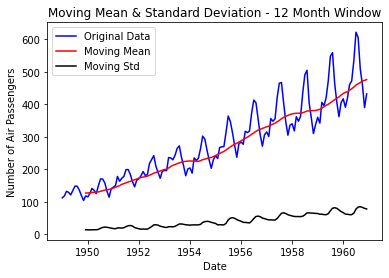

In [7]:
# moving statistics

mave = df.rolling(window=12).mean()  # moving average, 12 months in a year
mstd = df.rolling(window=12).std()


# plot with moving statistics

orig = plt.plot(df, color='blue', label='Original Data')
mean = plt.plot(mave, color='red', label='Moving Mean')
std = plt.plot(mstd, color='black', label='Moving Std')

plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Number of Air Passengers')
plt.title('Moving Mean & Standard Deviation - 12 Month Window')
plt.show()

**Note:** Here we can clearly see the moving average steadily increasing.

#### Using the Augmented Dickey-Fuller test
This calculates the statistical significance of a result using hypothesis testing, with the null hypothesis asserting that the data is not stationary.

In [8]:
# Augmented Dickey-Fuller test

df_test = adfuller(df['passengers'])  # returns a tuple of floats and dicts
df_adf = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value',
                                       '# Lags Used', '# Observations Used'])

for k,v in df_test[4].items():
    df_adf[f'Critical Value ({k})'] = v

print(df_adf)

Test Statistic            0.815369
p-value                   0.991880
# Lags Used              13.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


**Note:** The p-value is almost 1, so it is almost certain that the null hypothesis is true, meaning the data is not stationary

Let's create a function for these tests, so we can keep track of the stationarity as we transform the data

In [9]:
def test_stationarity(timeseries):
    
    # Moving statistics
    mave = timeseries.rolling(window=12).mean()  # moving average
    mstd = timeseries.rolling(window=12).std()  # moving standard deviation
    
    # plot moving stats
    plt.figure(figsize=(12,4))
    orig = plt.plot(timeseries, label='Original Data')
    mean = plt.plot(mave, color='red', label='Moving Mean')
    std = plt.plot(mstd, color='black', label='Moving Std')
    plt.legend(loc='best')
    plt.title('Moving Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller Test
    df_test = adfuller(timeseries['passengers'])
    df_adf = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value',
                                           '# Lags Used', '# Observations Used'])
    for k,v in df_test[4].items():
        df_adf[f'Critical Value ({k})'] = v
    print(df_adf)

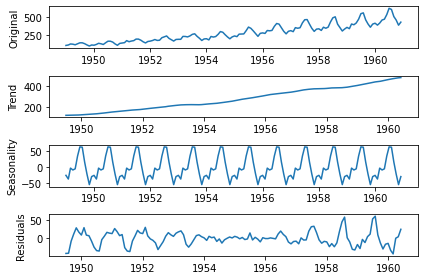

In [10]:
# time series components

decomposition = seasonal_decompose(df)

plt.subplot(411)
plt.plot(df)
plt.ylabel('Original')

plt.subplot(412)
plt.plot(decomposition.trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.ylabel('Seasonality')

plt.subplot(414)
plt.plot(decomposition.resid)
plt.ylabel('Residuals')

plt.tight_layout()

**Note:**

- Observed: The original data
- Trend: The overall trend, isolated from the rest of the features
- Seasonality: Varies from -50 to 50 with mean 0, with each cycle representing each year
- Residual: The noiseleft over after decomposition of the Trend and Seasonality

### 
## Transforming to Stationary Data

### Box Cox Transformation
We can use the Box-Cox transformation to make the variance constant in a series

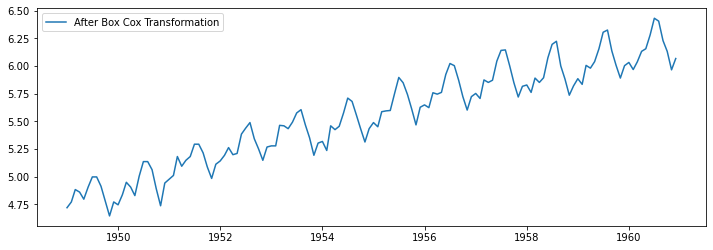

In [11]:
df_boxcox = pd.Series(boxcox(df['passengers'], lmbda=0), df.index)

# plotting
plt.figure(figsize=(12,4))
plt.plot(df_boxcox, label='After Box Cox Transformation')
plt.legend(loc='upper left')
plt.show()

**Note:** The variance becomes almost constant, exhibited by the similar height difference between the peaks and troughs of each cycle.

But we can still clearly observe an upward trend, so the mean is not constant yet.

### Differencing
Differencing is performed by subtracting the previous observation from the current observation. This can help us to remove the trend in a time series.

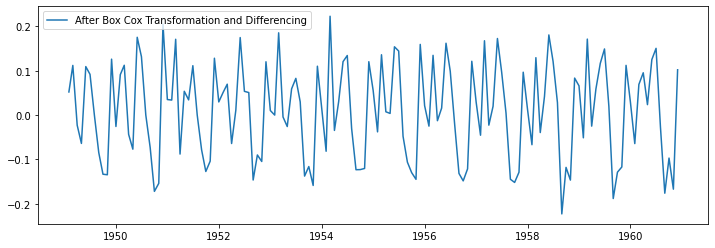

In [12]:
# Calculate diff between the previous and current observations.

df_boxcox_diff = pd.Series(df_boxcox - df_boxcox.shift(), index=df.index)
df_boxcox_diff.dropna(inplace=True)  # removing the 1st value, since it is null

# plotting
plt.figure(figsize=(12,4))
plt.plot(df_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='upper left')
plt.show()

**Note:** Visually, we see that the data is centred on y=0.0 and the variance is almost constant. So let's test the stationarity again.

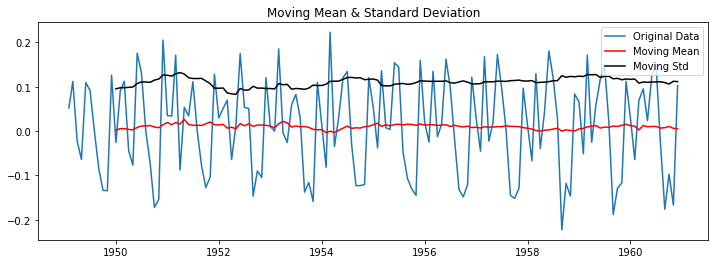

Test Statistic           -2.717131
p-value                   0.071121
# Lags Used              14.000000
# Observations Used     128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


In [13]:
df_boxcox_diff = df_boxcox_diff.to_frame()  # convert Series to DataFrame
df_boxcox_diff.columns = ['passengers']  # add col name, so function works

test_stationarity(df_boxcox_diff)

**Note:** The p-value is much smaller than the previous value of 0.99. And visually, the moving average is almost constant at zero. For the purposes of this project, we can assume the data is now stationary, so let's use this data going forward.

### 
### Train/Test Split
We'll forecast the last two years, 1959 & 1960.

In [14]:
# Splitting data_boxcox

train_len = len(df) - 24  # all data except the last 24 months

train = df[:train_len]
test = df[train_len:]  # 1959 and 1960 data

train_data_boxcox = df_boxcox[:train_len]
test_data_boxcox = df_boxcox[train_len:]

### 
## Building the SARIMA model

**SARIMA**: Seasonal Autoregressive Integrated Moving Average.

Seasonal ARIMA is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Reference: "*Forecasting: principles and practice*", 2013.

SARIMA performs the differencing internally, so we want to train it on the Box Cox data but test it against the Box Cox & Differenced data

In [15]:
# instantiate and fit the model

model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12), freq='MS')  # MS: month start
model_fit = model.fit()

# seasonal_order P=1, Q=1, D=1 and m=12 (because the seasonality is monthly)

c:\users\c.cannadine\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


**Note:**
order(p,d,q)

- p = Periods to lag for. p= 1, so we use the previous period of our time series in the autoregressive portion of the calculation. p helps adjust the line that is being fitted to forecast the series.

- d = The number of differencing transformations required by the time series to become stationary (we needed 1).

- q = The lag of the error component, which is a part of the time series not explained by trend or seasonality.

In [16]:
# predict the data

df_sarima = df_boxcox_diff.copy()
df_sarima['sarima_forecast_boxcox'] = model_fit.predict(df_boxcox_diff.index.min(),
                                                        df_boxcox_diff.index.max())
df_sarima['sarima_forecast'] = np.exp(df_sarima['sarima_forecast_boxcox'])  # use exponent to undo the logarithm

**Note:** Here we've calculated the exponent to restore the logarithmic values to their original state

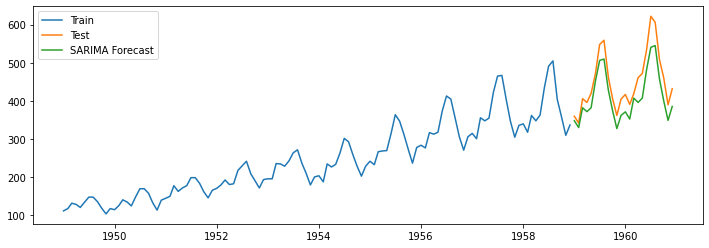

In [17]:
plt.figure(figsize=(12,4))
plt.plot(train['passengers'], label='Train')
plt.plot(test['passengers'], label='Test')
plt.plot(df_sarima['sarima_forecast'][test.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

**Note:** We see that the green forecast closely matches the observed data.

In [18]:
# Evaluation metrics

# Root mean squared error (normalized)
rmse = np.sqrt(mean_squared_error(test['passengers'], df_sarima['sarima_forecast'][test.index.min():]))
rmse = rmse/(df_sarima['sarima_forecast'].max() - df_sarima['sarima_forecast'].min())
rmse = round(rmse,2)

# Mean absolute percentage error
mape = round(np.mean(np.abs((test['passengers'] - df_sarima['sarima_forecast'][test.index.min():])/test['passengers'])*100),2)


print('RMSE: ', rmse, '\nMAPE: ', mape)

RMSE:  0.04 
MAPE:  8.82


**Note:** These relatively low values indicate a good model performance.

Using these metrics and the graph above, we can conclude that this SARIMA model satisfies our original goal of predicting the number of passengers.